In [33]:
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import PIL
from keras import layers
from keras import Sequential
from keras.layers import Conv2DTranspose, Conv2D, BatchNormalization, ReLU, LeakyReLU, Dropout, Dense, Activation, Input, Reshape
import keras
import time
from IPython import display

DATA_DIR='/home/evan/Datasets/tensorflow'
BUFFER_SIZE = 10000
BATCH_SIZE = 32
LOAD_CHECKPOINT = False

#run ochannelse to download
train_dataset = tfds.load('stanford_dogs', as_supervised=False, split='train', data_dir=DATA_DIR, download=True)
#normal operation
train_dataset = tfds.load('stanford_dogs', as_supervised=False, split='train', data_dir=DATA_DIR, download=False)

train_dataset = train_dataset.map(lambda x : x['image'])
# print(next(train.take(1).as_numpy_iterator()))
train_dataset = train_dataset.map(lambda x : tf.image.resize(x, (64,64)))
train_dataset = train_dataset.map(lambda x : tf.cast(x, tf.float32))
train_dataset = train_dataset.map(lambda x : (x - 127.5) / 127.5)  # Normalize the images to [-1, 1]
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


2021-10-26 12:20:06.913554: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


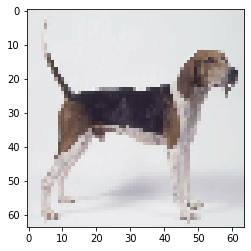

In [4]:
plt.imshow((next(train_dataset.as_numpy_iterator())[0]*127.5 +127.5)/255.)

In [51]:
num_epochs = 5
batch_size = 128

image_size = (64,64)

# Number of channels
channels = 3

# Size of latent vector (i.e. size of generator input)
latent_size = 120

# Size of feature maps in generator
filters_gen = 64

# Size of feature maps in discriminator
filters_dis = 64

#hyperparams for Adam
lr = 0.0002
beta1 = 0.5

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 12288)             1486848   
_________________________________________________________________
reshape_13 (Reshape)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_transpose_90 (Conv2DT (None, 64, 64, 512)       24576     
_________________________________________________________________
batch_normalization_69 (Batc (None, 64, 64, 512)       2048      
_________________________________________________________________
re_lu_69 (ReLU)              (None, 64, 64, 512)       0         
_________________________________________________________________
conv2d_transpose_91 (Conv2DT (None, 64, 64, 256)       2097152   
_________________________________________________________________
batch_normalization_70 (Batc (None, 64, 64, 256)     

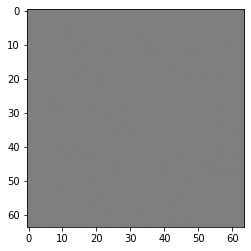

In [61]:
def make_generator_model():
    model = keras.Sequential([
            # input is Z, going into a convolution
            Input((latent_size)),
            Dense(np.prod((image_size)+(3,))),
            Reshape((image_size)+(3,)),
            Conv2DTranspose(filters = filters_gen * 8, kernel_size=4, strides=1, padding='same',use_bias=False),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(filters_gen * 4, 4, 1, padding='same',use_bias=False),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(filters_gen * 2, 4, 1,padding='same',use_bias=False),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(filters_gen, 4, 1, padding='same',use_bias=False),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(channels, 4, 1,padding='same',use_bias=False),
            Activation('tanh')
    ])
    return model

generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, latent_size])
generated_image = generator(noise, training=False).numpy()
print(generated_image.shape)
print(generated_image.sum())
plt.imshow(((generated_image[0, :, :, :]*127.5)+127.5)/255.)

In [64]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.AveragePooling2D((5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.AveragePooling2D((5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [65]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00011767]], shape=(1, 1), dtype=float32)


In [66]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [67]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [68]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta1)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta1)

In [69]:
checkpoint_dir = './training_checkpoints' + datetime.now().strftime("%H:%M:%S")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [70]:
EPOCHS = 200
noise_dim = 120
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [72]:
# Notice the use of `tf.fuchannelstion`
# This annotation causes the fuchannelstion to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [73]:
if LOAD_CHECKPOINT:
    ckpt = tf.train.Checkpoint(
        generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator
    )
    manager = tf.train.CheckpointManager(ckpt, './training_checkpoints/', max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)

In [74]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [75]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inferechannelse mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5)/255.)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [76]:
train(train_dataset, EPOCHS)
